In [1]:
import pandas as pd
import numpy as np
from numpy.random import normal
import seaborn as sb
import scipy as sc
import scipy.stats as st
from tqdm import tqdm
import time
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import random
import warnings

https://www.kaggle.com/atulanandjha/national-stock-exchange-time-series?select=tcs_stock.csv

In [2]:
source_data_path = "./../tcs_stock.csv"

In [3]:
raw_df = pd.read_csv(source_data_path)

## Data description
* Date - date on which data is recorded
* Symbol - NSE symbol of the stock
* Series - series of that stock | EQ - Equity
* Prev Close - last day close point
* Open - current day open point
* High - current day highest point
* Low - current day lowest point
* Last - the final quoted trading price for a particular stock, or stock-market index, during the most recent day of trading
* Close - closing point for the current day
* VWAP - volume-weighted average price is the ratio of the value traded to total volume traded over a particular time horizon

In [4]:
raw_df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,TCS,EQ,2558.25,2567.0,2567.00,2541.00,2550.00,2545.55,2548.51,183415,4.674345e+13,8002,52870,0.2883
1,2015-01-02,TCS,EQ,2545.55,2551.0,2590.95,2550.60,2588.40,2579.45,2568.19,462870,1.188740e+14,27585,309350,0.6683
2,2015-01-05,TCS,EQ,2579.45,2581.0,2599.90,2524.65,2538.10,2540.25,2563.94,877121,2.248886e+14,43234,456728,0.5207
3,2015-01-06,TCS,EQ,2540.25,2529.1,2529.10,2440.00,2450.05,2446.60,2466.90,1211892,2.989615e+14,84503,714306,0.5894
4,2015-01-07,TCS,EQ,2446.60,2470.0,2479.15,2407.45,2426.90,2417.70,2433.96,1318166,3.208362e+14,101741,886368,0.6724


## Step 1. Choose subsample with main variables for your further analysis. 

###  For this lab you need subsample with 3-5 random variables, at least half of them should be described with continuous random variable type

In [5]:
df = raw_df[['Open', 'High', 'Low', 'Close']]
df.head()

,Open,High,Low,Close
0,2567.0,2567.00,2541.00,2545.55
1,2551.0,2590.95,2550.60,2579.45
2,2581.0,2599.90,2524.65,2540.25
3,2529.1,2529.10,2440.00,2446.60
4,2470.0,2479.15,2407.45,2417.70


## Step 2. You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function (or probability law in case of discrete RV).

(for each variable)

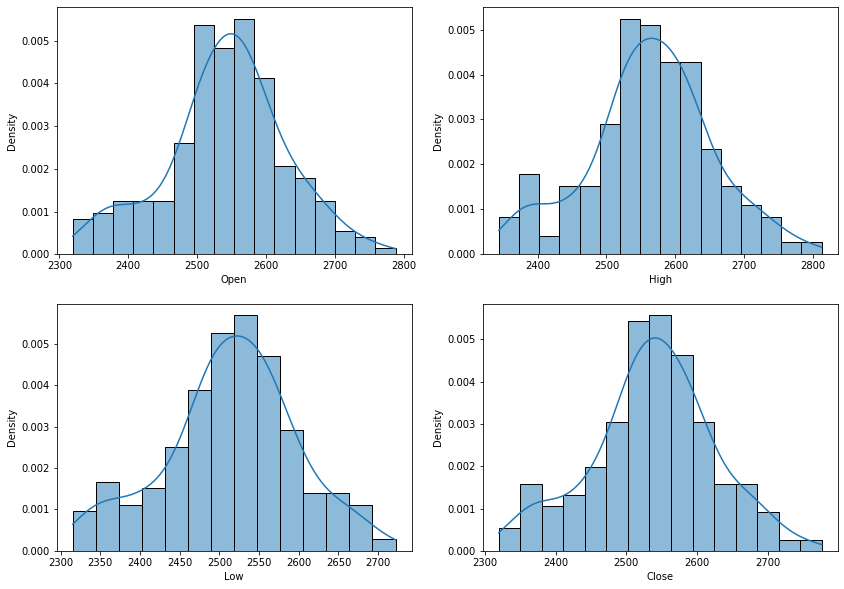

In [6]:
# initialize figure canvas
fig, ax = plt.subplots(2, 2, figsize=(14,10))
sb.histplot(df['Open'], ax=ax[0,0], kde=True, stat="density")
sb.histplot(df['High'], ax=ax[0,1], kde=True, stat="density")
sb.histplot(df['Low'], ax=ax[1,0], kde=True, stat="density")
sb.histplot(df['Close'], ax=ax[1,1], kde=True, stat="density")

plt.show()

## Step 3. You need to make an estimation of order statistics and represent them as “box with whiskers” plot.
we will find quintiles estimations


In [7]:
def quantilies(array):
    return [
        np.quantile(array, 0.1),
        np.quantile(array, 0.25), 
        np.quantile(array, 0.5), 
        np.quantile(array, 0.75),
        np.quantile(array, 0.9)
    ]

open_v = df['Open'].to_numpy()
open_v_quantiles = quantilies(open_v)

high = df['High'].to_numpy()
high_quantiles = quantilies(high)

last = df['Low'].to_numpy()
last_quantiles = quantilies(last)

close = df['Close'].to_numpy()
close_quantiles = quantilies(close)

print('Open: ', open_v_quantiles)
print('High: ', high_quantiles)
print('Low: ', last_quantiles)
print('Close: ', close_quantiles)

Open:  [2418.69, 2499.5, 2548.5, 2594.25, 2651.16]
High:  [2438.1549999999997, 2518.9, 2566.0, 2615.75, 2678.785]
Low:  [2400.455, 2472.1000000000004, 2520.0, 2567.2999999999997, 2611.8900000000003]
Close:  [2417.43, 2495.1499999999996, 2541.4750000000004, 2592.0, 2648.885]


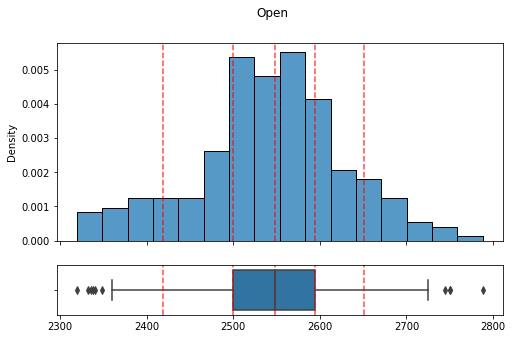

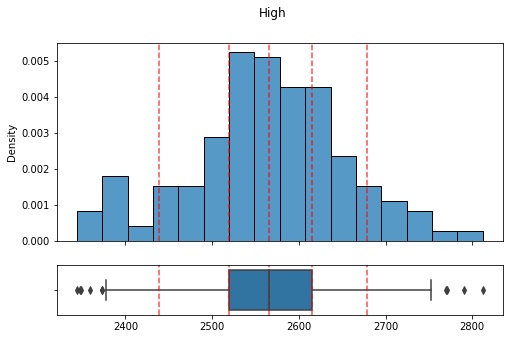

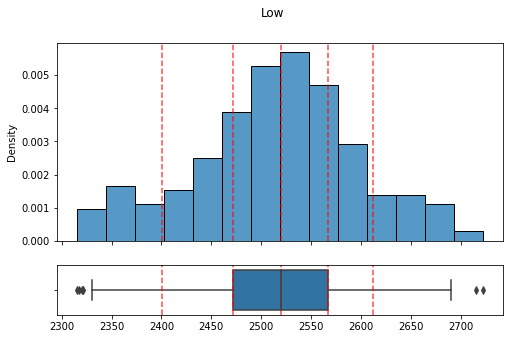

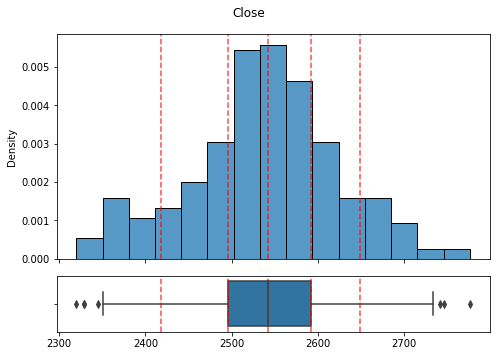

In [8]:
def draw(title, method, data, quantiles, width = 7):
    fig, ax = plt.subplots(2,1, figsize=(width, 5), sharex=True, gridspec_kw={'height_ratios': [2,0.5]})
    fig.suptitle(title)
    
    sb.histplot(data, ax=ax[0], kde = False, stat=method)
    for q in quantiles:
        ax[0].axvline(q, color='r', linestyle='--', alpha=0.7)

    sb.boxplot(x=data, ax=ax[1])
    for q in quantiles:
        ax[1].axvline(q, color='r', linestyle='--', alpha=0.7)

draw('Open', 'density', open_v, open_v_quantiles, 8)
draw('High', 'density', high, high_quantiles, 8)
draw('Low', 'density', last, last_quantiles, 8)
draw('Close', 'density', close, close_quantiles)

plt.tight_layout()
plt.show()

## Step 4. Find one or several theoretical distributions that could describe your sample on a basis of non-parametric analysis results.

In [9]:
def danoes_formula(data):
    """
    DANOE'S FORMULA
    https://en.wikipedia.org/wiki/Histogram#Doane's_formula
    """
    N = len(data)
    skewness = st.skew(data)
    sigma_g1 = math.sqrt((6*(N-2))/((N+1)*(N+3)))
    num_bins = 1 + math.log(N,2) + math.log(1+abs(skewness)/sigma_g1,2)
    num_bins = round(num_bins)
    return num_bins

def fit_data(data):
    ## st.frechet_r,st.frechet_l: are disabled in current SciPy version
    ## st.levy_stable: a lot of time of estimation parameters
    ALL_DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm, st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]
    
    MY_DISTRIBUTIONS = [st.invgauss]

    ## Calculae Histogram
    num_bins = danoes_formula(data)
    frequencies, bin_edges = np.histogram(data, num_bins, density=True)
    central_values = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

    results = {}
    for distribution in tqdm(ALL_DISTRIBUTIONS):
        ## Get parameters of distribution
        params = distribution.fit(data)
        
        ## Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
    
        ## Calculate fitted PDF and error with fit in distribution
        pdf_values = [distribution.pdf(c, loc=loc, scale=scale, *arg) for c in central_values]
        
        ## Calculate SSE (sum of squared estimate of errors)
        sse = np.sum(np.power(frequencies - pdf_values, 2.0))
        
        ## Build results and sort by sse
        results[distribution] = [sse, arg, loc, scale]
        
    results = {k: results[k] for k in sorted(results, key=results.get)}
    return results

In [10]:
def plot_histogram(data, results, n):
    ## n first distribution of the ranking
    N_DISTRIBUTIONS = {k: results[k] for k in list(results)[:n]}

    ## Histogram of data
    plt.figure(figsize=(10, 5))
    plt.hist(data, density=True, ec='black')
    plt.xlabel('Values')
    plt.ylabel('Frequencies')

    ## Plot n distributions
    for distribution, result in N_DISTRIBUTIONS.items():
        sse, arg, loc, scale = result
        x_plot = np.linspace(min(data), max(data), 1000)
        y_plot = distribution.pdf(x_plot, loc=loc, scale=scale, *arg)
        plt.plot(x_plot, y_plot, label=str(distribution)[32:-34] + ": " + str(sse)[0:6])
    
    plt.legend(title='Distributions (*e-07)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:13<00:00,  6.18it/s]


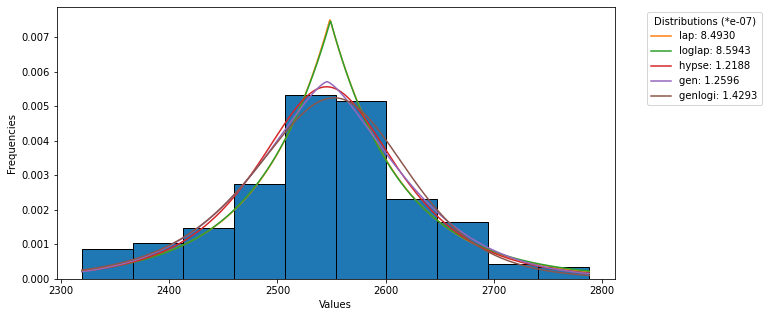

Best distribution for 'Open' feature is 'laplace'


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:13<00:00,  6.49it/s]


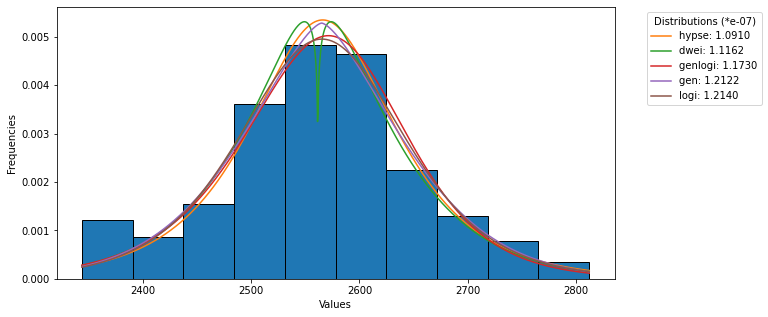

Best distribution for 'High' feature is 'hypsecant'


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:13<00:00,  6.19it/s]


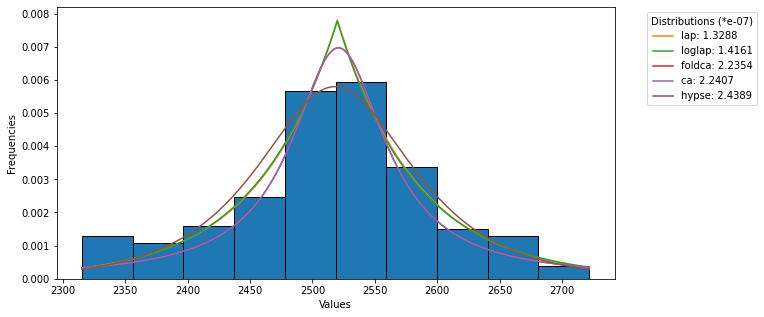

Best distribution for 'Low' feature is 'laplace'


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.58it/s]


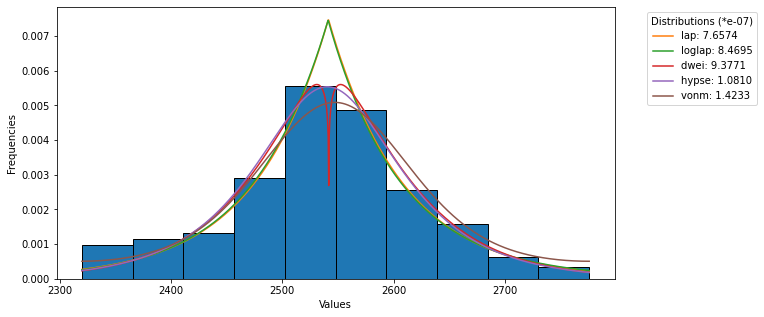

Best distribution for 'Close' feature is 'laplace'


In [11]:
for feature_name in df.keys():
    data = df[feature_name]
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        results = fit_data(data)
        plot_histogram(data, results, 5)
        first_value = next(iter(results.keys()))
        print("Best distribution for '{}' feature is '{}'".format(feature_name, first_value.name))
        time.sleep(1)

## Step 5. Estimate parameters of chosen distributions using methods of maximum likelihood and least squares method.

In [37]:
from scipy.stats import laplace, hypsecant
from scipy.optimize import leastsq as ls_new

def optimizer(func, x0, args, disp):
    return ls(func, x0, args)
    

open_MLE = laplace.fit(df['Open'], method='MLE')
open_MM = laplace.fit(df['Open'], method='MLE', optimizer = ls)

high_MLE = hypsecant.fit(df['High'], method='MLE')
high_MM = hypsecant.fit(df['High'], method='MLE', optimizer = ls_new)

low_MLE = laplace.fit(df['Low'], method='MLE')
low_MM = laplace.fit(df['Low'], method='MLE', optimizer = ls)

close_MLE = laplace.fit(df['Close'], method='MLE')
close_MM = laplace.fit(df['Close'], method='MLE', optimizer = ls)

print('Open')
print(f'MLE: {open_MLE}\nMM: {open_MM}', end='\n\n')

print('High')
print(f'MLE: {high_MLE}\nMM: {high_MM}', end='\n\n')

print('Low')
print(f'MLE: {low_MLE}\nMM: {low_MM}', end='\n\n')

print('Close')
print(f'MLE: {close_MLE}\nMM: {close_MM}')

TypeError: leastsq() got an unexpected keyword argument 'disp'

In [15]:
a = laplace.fit(df['Open'])

In [16]:
from scipy.optimize import least_squares as ls

In [19]:
ls(laplace(), df['Open'])

TypeError: 'rv_frozen' object is not callable

In [29]:
laplace.fit(df['Open'], optimizer = ls)

(2548.5, 66.47842741935482)

In [28]:
values

array([0.00569418, 0.00724364, 0.00461287, 0.00561761, 0.00230919,
       0.00152459, 0.00184275, 0.00468278, 0.00489895, 0.00461287,
       0.00595703, 0.00699732, 0.00623201, 0.00489895, 0.00504857,
       0.0046477 , 0.00447616, 0.00436643, 0.00379353, 0.00642235,
       0.0062602 , 0.00276601, 0.00432069, 0.00560917, 0.00489895,
       0.00702897, 0.00618532, 0.00421477, 0.00184414, 0.00267597,
       0.00230919, 0.00632647, 0.00434023, 0.0020168 , 0.00078415,
       0.00119128, 0.00084286, 0.00066257, 0.00105621, 0.00141732,
       0.00108847, 0.00104515, 0.00100961, 0.00020496, 0.00036301,
       0.00189903, 0.00166108, 0.00184275, 0.00241942, 0.00195703,
       0.00433045, 0.00450995, 0.00397163, 0.0049732 , 0.00368111,
       0.00272471, 0.0022073 , 0.00394484, 0.00699732, 0.00578048,
       0.00528162, 0.00548815, 0.00651969, 0.00651969, 0.00609756,
       0.00379353, 0.00142695, 0.0016711 , 0.00132356, 0.0015223 ,
       0.00231093, 0.00660856, 0.00268605, 0.00124253, 0.00129

## Step 6. Validate your estimated parameters using QQ biplots.

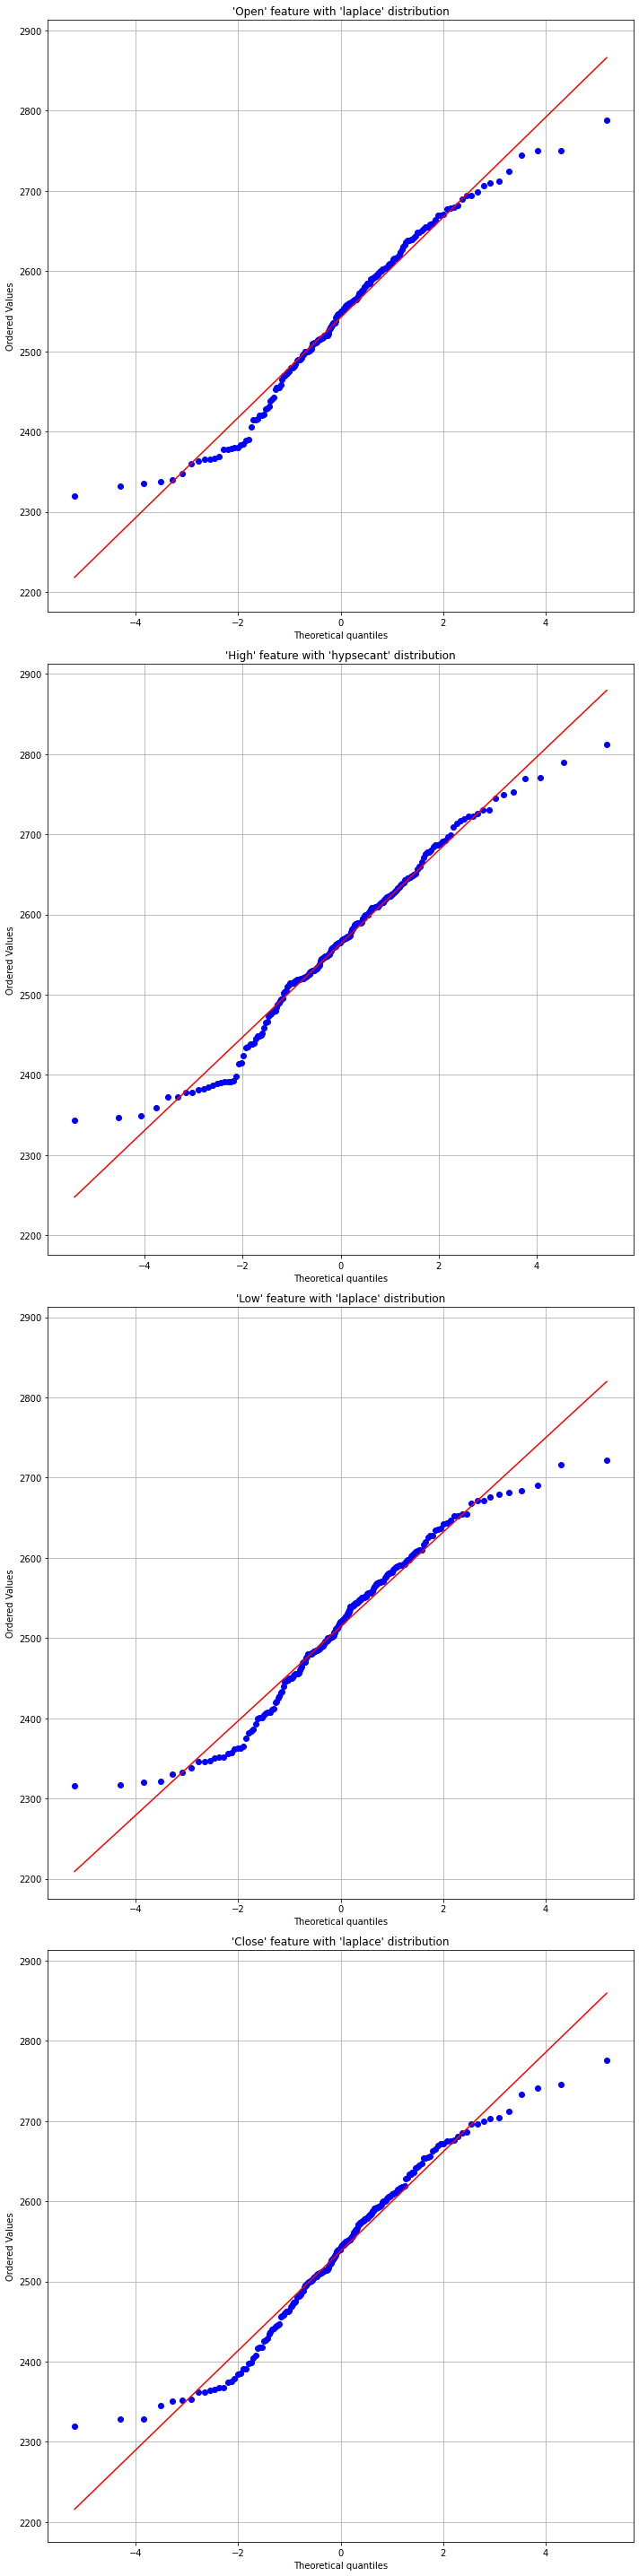

In [13]:
columns = ['Open', 'High', 'Low', 'Close']
distributions = [laplace, hypsecant, laplace, laplace]

fig, ax = plt.subplots(len(columns), 1, figsize=(10, 10*len(columns)), sharey=True)

for distribution, col, i in zip(distributions, columns, range(0, len(columns))):
    feature = df[col]
    
    percs = np.linspace(0,100,21)
    qn_feature = np.percentile(feature, percs)    
    x = np.linspace(np.min(feature), np.max(feature))
    st.probplot(feature, dist = distribution, plot=ax[i])
    ax[i].set_title(f"'{col}' feature with '{distribution.name}' distribution")
    ax[i].grid()

plt.tight_layout()
plt.show()

The points from all plots seem to fall about a straight line. So we can conclude that the theoretical distribution is close to the real distribution of the data.

## Step 7. Estimate correctness of fitted distributions using at least 2 statistical tests.

In [43]:
columns = ['Open', 'High', 'Low', 'Close']
dist = [st.laplace, st.hypsecant, st.laplace, st.laplace]

for col, dst in list(zip(columns, dist)):
    data = df[col]
    a, b = dst.fit(data)
    l1 = dst(a, b)
    
    ks_p_value = st.kstest(data, l1.cdf).pvalue
    cm_p_value = st.cramervonmises(data, l1.cdf).pvalue

    print(f"Result for '{col}'")
    print("Kolmogorov-Smirnov test: p-value = ", ks_p_value)
    print("Cramér-von Mises test: p-value = ", cm_p_value)
    print("")

Result for 'Open'
Kolmogorov-Smirnov test: p-value =  0.2945892478928587
Cramér-von Mises test: p-value =  0.5980876041242682

Result for 'High'
Kolmogorov-Smirnov test: p-value =  0.8395566093601524
Cramér-von Mises test: p-value =  0.8947212156051837

Result for 'Low'
Kolmogorov-Smirnov test: p-value =  0.4962830863565647
Cramér-von Mises test: p-value =  0.5120218278609918

Result for 'Close'
Kolmogorov-Smirnov test: p-value =  0.4782554079997128
Cramér-von Mises test: p-value =  0.7048860495172959



As we can see here p-value > 0.05 for all described features. Then we can say that theoretical distribution and real distribution of our data is quite similar.